# <span style="color:darkblue"> Laboratorio di Simulazione Numerica </span>
#### <span style="color:darkred">  Riccardo Beccaria - Luglio 2021</span>

# <span style="color:green"> Esercitazione 3<span>

### Esercizio 03.1

By using the following parameters: 
- asset price at $t=0$: $S(0)=100$
- delivery time: $T=1$
- strike price: $K=100$
- risk-free interest rate: $r=0.1$
- volatility: $\sigma=0.25$

compute at time $t=0$ via Monte Carlo the European call-option price, $C[S(0),0]$, and put-option price, $P[S(0),0]$:

1.  By sampling directly the final asset price $S(T)$ for a $GBM(r,\sigma^2)$
2.  By sampling the discretized $GBM(r,\sigma^2)$ path of the asset price
dividing $[0,T]$ in $10^2$ time intervals: $S(0)$, $S(t_1)$, $S(t_2)$, ... up to $S(t_{100}=T=1)$

In questa esercitazione ho sviluppato un codice per calcolare i prezzi di azioni finanziarie: ho investigato il costo di una particolare tipologia di opzioni. Le opzioni sono contratti in cui uno dei due partners assume un obbligo, mentre l'altro assume un diritto. Le opzioni che ho simulato sono le opzioni europee. Nelle opzioni europee il venditore (anche detto *seller*) garantisce al compratore (anche detto *holder*) il diritto di comprare (*call*) o di vendere (*put*) un oggetto con un prezzo $S(t)$ (a qualunque tempo $t$), a un prezzo *K* detto *strike prize* pattuito precedentemente.

Il punto chiave di queste opzioni europee è che solo l'*holder* ha il diritto di esercitare la compra o la vendita, mentre il *seller* ha l'obbligo di rispettare tale scelta. Per cui:
- L'holder eserciterà il suo diritto di comprare se al tempo T pattuita si ha $S(T)>K$.
- Mentre eserciterà il suo diritto di vendita se al tempo pattuito T si ha $S(T)<K$.

Per questa ragione si definisce in modo intuitivo il profitto$=max[0, S(T)-K]$ per una *call*, e il profitto$=max[0, K-S(T)]$ per una *put*.


Le assunzioni sotto cui si lavora sono le assunzioni della teoria di Black-Scholes. Questa teoria prevede di rispondere alla domanda di quanto dovrebbero costare le opzioni europee, e lavora sulle assunzioni che: il mercato sia infinitamente liquido ed efficiente, e che il costo istantaneo dei prezzi segua un <font color="red">Moto Browniano Geometrico</font> a coefficienti costanti.

Un *GBM* Moto Browniano Geometrico è un processo stocastico la cui osservabile (nel mio caso il prezzo $S(t)$) ha il logaritmo che segue un Processo di Wiener:

$$dS_t=r S_t dt + \sigma S_tdW_t$$

Dove $W_t$ è un processo di Wiener: un processo stocastico gaussiano con incrementi indipendenti. Nel nostro caso il *GBM* è a coefficienti costanti. Questa equazione differenziale stocastica ha come soluzione:

$$ S(T)=S(0)e^{\left[(r-\frac{1}{2}\sigma^2)T + \sigma (W_t - W_0)\right]}$$

Pertanto dal momento che $W_t$ è un processo di Wieniner, la quantità $N(0,T):=W_t - W_0$ è una variabile distribuita normalmente con media $0$ e varianza $T$.


Allora operativamente, quello che faccio nel codice è estrarre una variabile distribuita normalmente con varianza nulla e deviazione standard $T$, calcolo $S(T)=S(0)e^{\left[(r-\frac{1}{2}\sigma^2)T + \sigma N(0,T)\right]}$ così da poter valutare il profitto pari a $max[0,S(T)-K]$ per una *call* e pari a $max[0,K-S(T)]$ per una *put*. Da ultimo, a questo profitto moltiplico il termine $e^{-rT}$ a causa dell'interesse che un eventuale deposito in banca avrebbe garantito. In questo modo ho trovato il costo per una opzione europea di call $C[S(0),0]$ e per una opzione europea di put $P[S(0,0)]$.

<font color="red">N.B.</font> Nella teoria di Black-Scholes è prevista anche una soluzione analitica quì sotto riportata così da confontare le mie simulazioni Monte Carlo con questo valore atteso.

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import math
import numpy as np
from scipy.optimize import curve_fit
%config InlineBackend.figure_format = 'retina'
import scipy
from scipy.special import erf
from numpy.lib.scimath import sqrt, log
from numpy import exp



S0 = 100.
K = 100.
T = 1.
r = 0.1
sigma = 0.25
t=0

def N(x):
    return 0.5 * (1. + erf(x / sqrt(2.)))

def black_scholes(S0, K, T, r, sigma):
    d1 = 1./(sigma * sqrt(T)) * (log(S0 / K) + (r + (sigma**2) / 2.) * T)
    d2 = d1 - sigma * sqrt(T)
    C = S0 * N(d1) - K * exp(-r * T) * N(d2)
    P = S0 *(N(d1) - 1.) - K * exp(-r * T) * (N(d2)-1.)
    return C, P

if __name__ == "__main__":
    call, put = black_scholes(S0, K, T, r, sigma)
    print(" == BLACK-SCHOLES Analytic solution ==")
    print("      call: ", call)
    print("      put: ", put)

 == BLACK-SCHOLES Analytic solution ==
      call:  14.975790778311286
      put:  5.4595325819072364


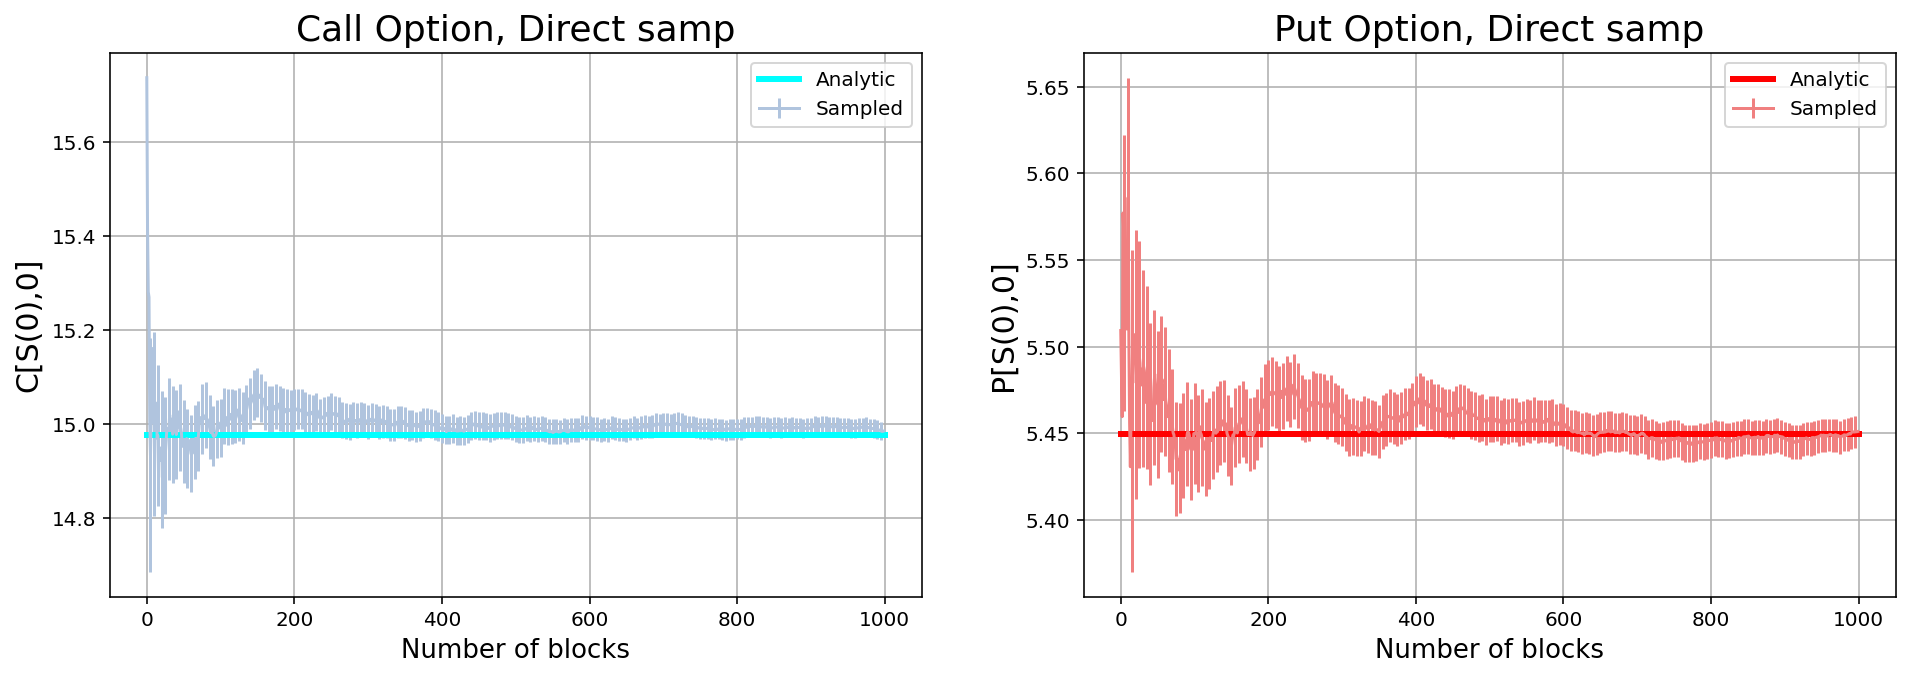

In [2]:
call_cost,error = np.loadtxt("./03.1/Call_cost.txt", usecols=(0,2), delimiter=' ', unpack='true')
put_cost,error_put = np.loadtxt("./03.1/Put_cost.txt", usecols=(0,2), delimiter=' ', unpack='true')
N=1000
M=1000000
L=int(M/N)

x = np.arange(N)
x*=L

fig, axs = plt.subplots(1, 2, figsize=(16,5))

axs[0].errorbar(x/L,call_cost,yerr=error,c='lightsteelblue', errorevery=5, label='Sampled')
axs[0].plot([0, N], [14.975790778311286, 14.975790778311286], color='aqua', linewidth=3, label='Analytic')
axs[0].set_ylabel(r'C[S(0),0]', fontsize=15)
axs[0].set_title(r'Call Option, Direct samp', fontsize=18)

axs[1].errorbar(x/L,put_cost,yerr=error_put,c='lightcoral', errorevery=5, label='Sampled')
axs[1].plot([0, N], [5.4495325819072364, 5.4495325819072364], color='red', linewidth=3, label='Analytic')
axs[1].set_ylabel(r'P[S(0),0]', fontsize=15)
axs[1].set_title(r'Put Option, Direct samp', fontsize=18)

for ax in axs.flat:
    ax.grid()
    ax.set_xlabel(r'Number of blocks', fontsize=13)
    ax.grid(True)
    ax.legend()

Ho eseguito $10^6$ estrazioni del valore di $S(T)$ dividendole in un $1000$ blocchi. In questo modo ho potuto utilizzare il metodo di Data Blocking con le funzioni implementate spiegate nelle esercitazioni precedenti.
Come si può osservare dai grafici, le estrazioni cominciano ad arrivare a convergenza entro una deviazione standard già dopo 300 blocchi: i valori analitici confermano i risultati Monte Carlo ottenuti.

Nella seconda parte del codice, per poter calcolare il prezzo $S(T)$, ho invece campionato il *GBM* in modo discreto dividendo l'intervallo $[0,T]$ in 100 intervallini più piccoli. Il problema dal punto di vista formale è identico a quello già presentato. L'unica differenza è che non viene predetto il prezzo $S(T)$ conoscendo il solo prezzo $S(0)$ all'istante zero, ma viene simulato il prezzo ad ogni tempo $t_i$ con $i \in[0,99]$ con $t_0=0$ e $t_{99}=T$.

Così, se si conosce il prezzo all'istante $t_i$, è possibile conoscere il prezzo all'istante $t_{i+1}$ attraverso la stessa relazione presentata prima. L'unica differenza è che la variabile $N$ precedentemente estratta con distribuzione normale a media nulla e varianza $T$, viene rimpiazzata da una variabile $Z_i$ estratta normalmente con media nulla e varianza $1$ e opportunamente moltiplicata per la radice (è un processo di Wiener) dell'ampiezza dell'intervallo temporale trascorso:

$$S_{t_{i+1}} = S_{t_i} e^{\left[(r-\frac{1}{2}\sigma^2)\cdot(t_{i+1} -t_i) + \sigma Z_{i+1} \sqrt{t_{i+1}-t_i}\right]}$$

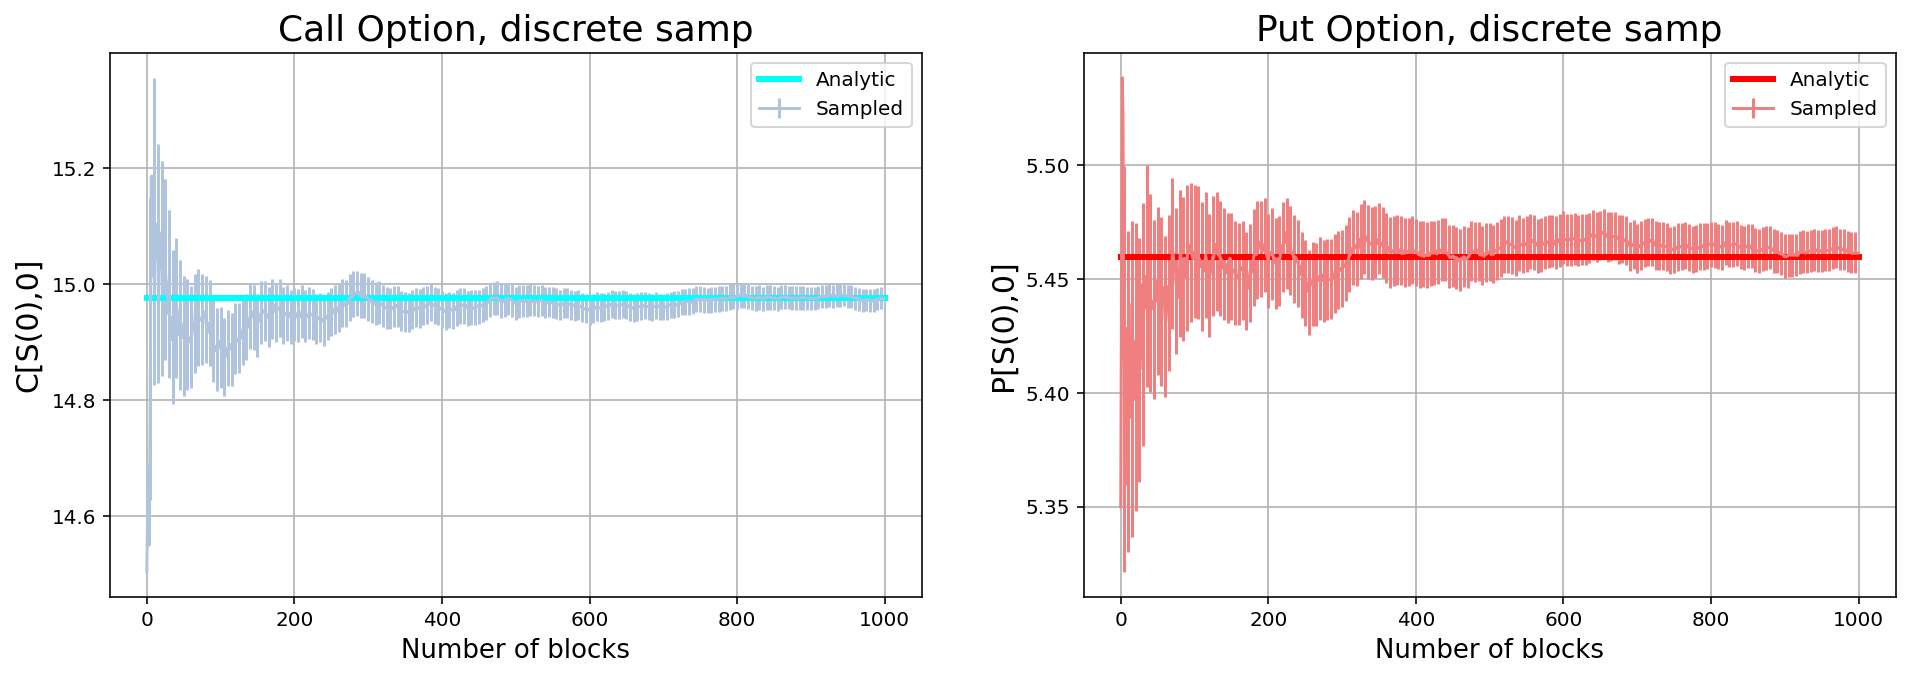

In [3]:
call_cost_discrete,error_discrete = np.loadtxt("./03.1/Call_cost_discrete.txt", usecols=(0,2), delimiter=' ', unpack='true')
put_cost_discrete,error_put_discrete = np.loadtxt("./03.1/Put_cost_discrete.txt", usecols=(0,2), delimiter=' ', unpack='true')

fig, axs = plt.subplots(1, 2, figsize=(16,5))

axs[0].errorbar(x/L,call_cost_discrete,yerr=error_discrete,c='lightsteelblue', errorevery=5, label='Sampled')
axs[0].plot([0, N], [14.975790778311286, 14.975790778311286], color='aqua', linewidth=3, label='Analytic')
axs[0].set_ylabel(r'C[S(0),0]', fontsize=15)
axs[0].set_title(r'Call Option, discrete samp', fontsize=18)

axs[1].errorbar(x/L,put_cost_discrete,yerr=error_put_discrete,c='lightcoral', errorevery=5, label='Sampled')
axs[1].plot([0, N], [5.4595325819072364, 5.4595325819072364], color='red', linewidth=3, label='Analytic')
axs[1].set_ylabel(r'P[S(0),0]', fontsize=15)
axs[1].set_title(r'Put Option, discrete samp', fontsize=18)

for ax in axs.flat:
    ax.grid()
    ax.set_xlabel(r'Number of blocks', fontsize=13)
    ax.grid(True)
    ax.legend()

Anche in questo caso il valore del prezzo $S(T)$ ottenuto attraverso un campionamento discreto del Moto Browniano Geometrico *GBM* converge entro una deviazione al valore analitico atteso dalla Teoria di Balck-Scholes. Anche in questo caso ho compiuto $10^6$ estrazioni suddivise in mille blocchi per utilizzare il metodo di Data Blocking per analizzare le estrazioni.

Pertanto il codice, in entrambi i casi predice correttamente il valore di queste due opzioni europee.